In [1]:
!pip install tqdm

In [2]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
import utils
from functools import partial

In [3]:
from utils import KernelFunction, KernelEnvironment
from utils import plot_kernel_function, compare_kernels

## Testing Kernel Functions


In [4]:
k = KernelFunction()
print(k)
k1 = k.rbf(lengthscale=1.0)
print(k1)
k2 = k.linear(variances=0.5)
k3 = k1.add(k2).multiply(k.linear(variances=2.0))

print(k3)
# Output: ((RBF({'lengthscale': 1.0, 'variance': 1.0}) + Linear({'variances': 0.5})) * Linear({'variances': 2.0}))

None({})
RBF({'lengthscale': 1.0, 'variance': 1.0})
((RBF({'lengthscale': 1.0, 'variance': 1.0}) + Linear({'variances': 0.5})) * Linear({'variances': 2.0}))


In [5]:
# Step 1: Generate synthetic data
np.random.seed(42)

# Inputs: 50 points in [0, 10]
X = np.linspace(0, 10, 50)[:, None]

# Ground-truth function: nonlinear + linear trend
Y_true = np.sin(X) + 0.5 * X
Y = Y_true + 0.3 * np.random.randn(*X.shape)  # add noise

# Step 2: Define composite kernel k3 = (RBF + Linear) * Linear
input_dim = X.shape[1]

# Step 3: Create and optimize GP model
real_k3 = k3.evaluate(input_dim=X.shape[1])
model = GPy.models.GPRegression(X, Y, kernel=real_k3)
model.optimize(messages=True)

# Print model info
print(model)

# Step 4: Predict and plot
Xtest = np.linspace(0, 10, 200)[:, None]
mean, var = model.predict(Xtest)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    00s01  0001   7.507626e+01   2.582879e+02 
    00s05  0005   2.532184e+01   1.235584e+01 
    00s14  0015   2.252140e+01   4.305033e-02 
    00s19  0020   2.250607e+01   1.024568e-02 
    00s41  0054   2.250370e+01   1.814082e-07 
Runtime:     00s41
Optimization status: Converged


Name : GP regression
Objective : 22.50370157650146
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.            |                  value  |  constraints  |  priors
  mul.sum.rbf.variance      |     10.057389982767729  |      +ve      |        
  mul.sum.rbf.lengthscale   |     3.5177481434056066  |      +ve      |        
  mul.sum.linear.variances  |  4.534464658764253e-08  |      +ve      |        
  mul.linear.variances      |    0.14238011833170008  |      +ve      |        
  Gaussian_noise.variance   |    0.07256832999332226  |      +ve      |        


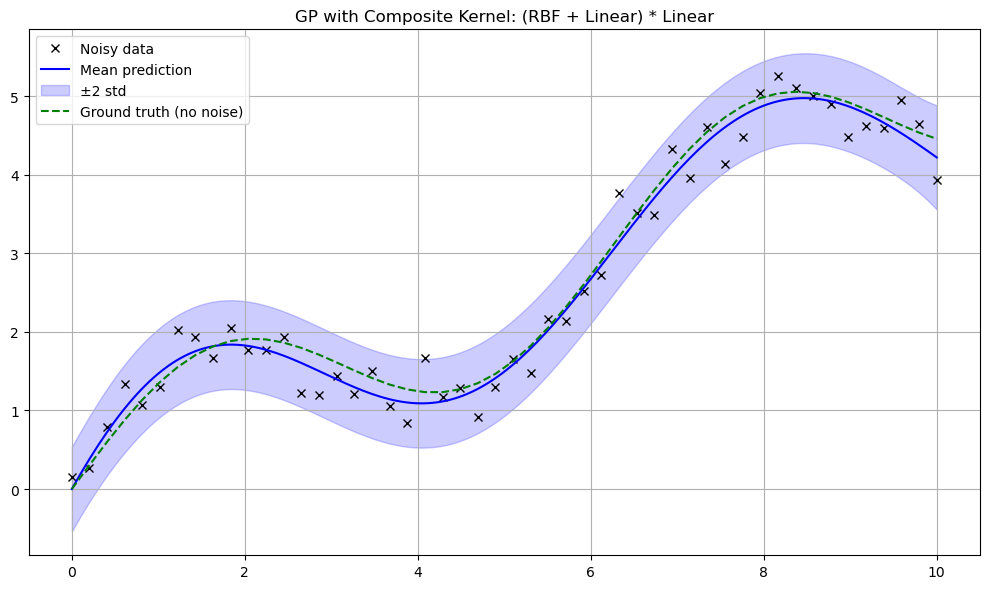

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(X, Y, "kx", label="Noisy data")
plt.plot(Xtest, mean, "b", label="Mean prediction")
plt.fill_between(Xtest.flatten(),
                 mean.flatten() - 2 * np.sqrt(var.flatten()),
                 mean.flatten() + 2 * np.sqrt(var.flatten()),
                 color="blue", alpha=0.2, label="±2 std")
plt.plot(X, Y_true, "g--", label="Ground truth (no noise)")
plt.title("GP with Composite Kernel: (RBF + Linear) * Linear")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Testing `generate_kernel`

In [7]:
true_kernel = KernelFunction().periodic(period=3.0, lengthscale=0.01)
# generating synthetic data
X, Y, true_kernel_str = utils.generate_gp_data(true_kernel, input_dim=1, n_points=50, noise_var=1e-3)

print("True Kernel:", true_kernel_str)

True Kernel: Periodic({'period': 3.0, 'variance': 1.0, 'lengthscale': 0.01})


In [8]:
# candidate kernel
candidate_kernel = KernelFunction().linear()

log_likelihood = utils.evaluate_likelihood(true_kernel, X, Y, runtime=False)
print("Log Marginal Likelihood (true kernel):", log_likelihood)
log_likelihood = utils.evaluate_likelihood(candidate_kernel, X, Y, runtime=False)
print("Log Marginal Likelihood (candidate kernel):", log_likelihood)

Log Marginal Likelihood (true kernel): 94.71843592618904
Log Marginal Likelihood (candidate kernel): 29.489464137433252


In [9]:
k1 = KernelFunction().linear(variances=1.0)
k2 = KernelFunction().rbf(lengthscale=0.001)

print(utils.evaluate_likelihood(k1, X, Y, runtime=False))
print(utils.evaluate_likelihood(k2, X, Y, runtime=False))

29.489464137433252
30.820478401527566


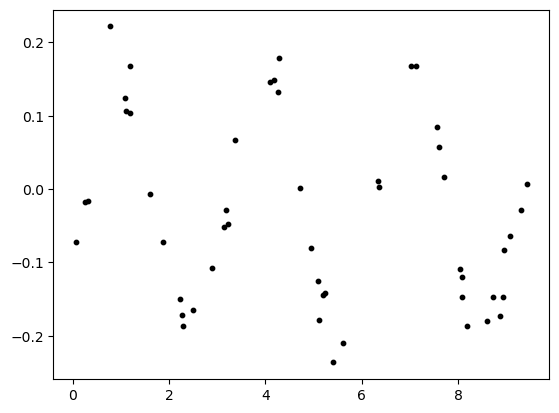

In [10]:
#plot the true kernel and candidate kernel and data points
plt.scatter(X, Y, color='black', s=10, label='Data Points')

In [11]:
np.exp(-33)  # convert log likelihood to likelihood

4.658886145103397e-15

## Testing Kernel Env

In [12]:
from gflownet import GFlowNet 

### Testing log likelihood reward

In [13]:
global reward_calls
reward_calls = 0
def log_likelihood_reward(X, Y, env: 'KernelEnvironment'):
    """
    Computes the log marginal likelihood of each kernel in the environment
    given the data (X, Y).
    """
    global reward_calls
    reward_calls += 1
    rewards = []
    for k in env.state: 
        log_likelihood = utils.evaluate_likelihood(k, X, Y)
        #print(np.log(1 + np.exp(-0.5 * (log_likelihood - 5))))
        reward = 1 / np.log(1 + np.exp(-0.05 * (log_likelihood))) 
        reward += + 1e-9
        rewards.append(reward if log_likelihood is not None else 1e-10)
        #rewards.append(log_likelihood**(3/2) if log_likelihood is not None else 1e-10)
    return torch.tensor(rewards, dtype=torch.float32) 

In [14]:
 1 / np.log(1 + np.exp(-0.05 * (80))) 

55.09663754745501

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np

# Function to Featurize the Environment State so the nn can assess it


class ForwardPolicy(nn.Module):
    """
    A simple MLP that takes a featurized state and outputs action logits
    and the state flow value log F(s).
    """
    def __init__(self, input_dim, output_dim,epsilon=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim + 1) # +1 for the state flow log F(s)
        )

        self.epsilon = epsilon  # Exploration rate for epsilon-greedy sampling

    def forward(self, batch_state, actions=None):
        
        
        features = batch_state.featurize_state()
        policy = self.net(features)

        epsilon = 0. if not self.training else self.epsilon
        #print(epsilon)
        unif_policy = torch.ones_like(policy) / policy.size(1)

        output = policy * (1 - epsilon) + epsilon * unif_policy
        
        logits, state_flow = output[:, :-1], output[:, -1]
        
        # Apply the environment's mask
        logits[~batch_state.mask] = -torch.inf
        
        # Find rows where all actions were masked (all logits are -inf)
        all_masked_rows = torch.all(torch.isneginf(logits), dim=1)
        # For those rows, set the first logit to 0.0 to prevent invalid dist
        # This allows sampling an action that will be ignored 
        if all_masked_rows.any():
            logits[all_masked_rows, 0] = 0.0

        if actions is None:
            dist = Categorical(logits=logits)
            actions = dist.sample()
            log_probs = dist.log_prob(actions)
        else:
            log_probs = Categorical(logits=logits).log_prob(actions)
            
        return actions, log_probs.squeeze(), state_flow.squeeze()



class BackwardPolicy:
    """
    A trivial backward policy for deterministic environments.
    It returns a log-probability of 0, corresponding to a true probability of 1.
    """
    def __call__(self, batch_state, actions):
        batch_size = batch_state.batch_size
        log_probs = torch.zeros(batch_size)
        

        return None, log_probs


In [16]:
list(utils._likelihood_cache.values())[:3]

[94.71843592618904, 29.489464137433252, 30.820478401527566]

In [17]:
from itertools import chain 

In [18]:
from utils import train

# def train(gflownet, create_env, epochs, batch_size, lr=1e-3, 
#             min_eps=1e-2, clamp_g=None, use_scheduler=True):
BATCH_SIZE = 64
MAX_LEN = 4

log_reward_fn = partial(log_likelihood_reward, X, Y)

def create_env(batch_size=BATCH_SIZE):
    return KernelEnvironment(
    batch_size=batch_size,
    max_trajectory_length=MAX_LEN,
    log_reward=log_reward_fn
)

env = create_env()

forward_model = ForwardPolicy(input_dim=MAX_LEN, output_dim=env.action_space_size, epsilon=0.5)
backward_model = BackwardPolicy()

gflownet = GFlowNet(
    forward_flow=forward_model, 
    backward_flow=backward_model, 
    criterion='tb'
)

epochs = 1000
batch_size = BATCH_SIZE
lr = 1e-4
train(
    gflownet=gflownet,
    create_env=create_env,
    epochs=epochs,
    batch_size=BATCH_SIZE,
    lr=lr,
    min_eps=1e-2,#should have clamp g set
    clamp_g= None,
    use_scheduler=True
)

100%|██████████| 1000/1000 [01:19<00:00, 12.64it/s, loss=192]  


(GFlowNet(
   (forward_flow): ForwardPolicy(
     (net): Sequential(
       (0): Linear(in_features=4, out_features=128, bias=True)
       (1): ReLU()
       (2): Linear(in_features=128, out_features=64, bias=True)
       (3): ReLU()
       (4): Linear(in_features=64, out_features=14, bias=True)
     )
   )
 ),
 [669.4559936523438,
  1024.8240966796875,
  596.9818115234375,
  756.1542358398438,
  735.2623901367188,
  768.1148071289062,
  821.5977172851562,
  826.6987915039062,
  698.2080078125,
  756.9398193359375,
  694.184814453125,
  779.080810546875,
  815.99560546875,
  899.3876342773438,
  691.8628540039062,
  844.7047729492188,
  583.7210083007812,
  704.85546875,
  698.3421630859375,
  555.5770263671875,
  790.3257446289062,
  615.484619140625,
  786.5858154296875,
  780.5653686523438,
  531.6097412109375,
  585.396728515625,
  893.156005859375,
  1007.5992431640625,
  647.16748046875,
  725.7281494140625,
  865.3258666992188,
  910.6903076171875,
  887.3539428710938,
  828.463

In [21]:
# --- Sampling from the Trained GFlowNet ---
print("\n Sampling 25 kernels from the trained model...")
eval_env = KernelEnvironment(
    batch_size=25,
    max_trajectory_length=MAX_LEN,
    log_reward=log_reward_fn
)

gflownet.eval()
final_batch_ll = gflownet.sample(eval_env)

# Expect to see kernels with high log likelihood
for i, kernel in enumerate(final_batch_ll.state):
    print(f"Sample {i+1}: {kernel}, Reward: {1 / np.log(1 + np.exp(-0.05 * (utils.evaluate_likelihood(kernel, X, Y))))}, Log Likelihood: {utils.evaluate_likelihood(kernel, X, Y):.4f}")


 Sampling 25 kernels from the trained model...
Sample 1: ((WhiteNoise({'variance': 1.0}) + RBF({'lengthscale': 1.0, 'variance': 1.0})) * RBF({'lengthscale': 1.0, 'variance': 1.0})), Reward: 19.827014112895576, Log Likelihood: 59.2344
Sample 2: ((Periodic({'period': 1.0, 'variance': 1.0, 'lengthscale': 1.0}) * RQ({'lengthscale': 1.0, 'variance': 1.0})) + RQ({'lengthscale': 1.0, 'variance': 1.0})), Reward: 45.41449998302024, Log Likelihood: 76.0960
Sample 3: ((Periodic({'period': 1.0, 'variance': 1.0, 'lengthscale': 1.0}) * Periodic({'period': 1.0, 'variance': 1.0, 'lengthscale': 1.0})) + RQ({'lengthscale': 1.0, 'variance': 1.0})), Reward: 29.820041380200067, Log Likelihood: 67.5673
Sample 4: ((RQ({'lengthscale': 1.0, 'variance': 1.0}) * RBF({'lengthscale': 1.0, 'variance': 1.0})) + RQ({'lengthscale': 1.0, 'variance': 1.0})), Reward: 35.12735638760806, Log Likelihood: 70.8943
Sample 5: ((Constant({'variance': 1.0}) + RQ({'lengthscale': 1.0, 'variance': 1.0})) * RBF({'lengthscale': 1.0, 

In [ ]:
np.exp(-745)

5e-324

In [ ]:
GPy.kern.RBF(10,verbose=False)

TypeError: RBF.__init__() got an unexpected keyword argument 'verbose'

In [ ]:
sum_final_batch_ll = 0 
for kernel in final_batch.state:
    sum_final_batch_ll += utils.evaluate_likelihood(kernel, X, Y)
print(f"Mean log likelihood for random kernels: {sum_final_batch_ll /len(final_batch.state):.4f}")

sum_final_batch_ll = 0
for kernel in final_batch_ll.state:
    sum_final_batch_ll += utils.evaluate_likelihood(kernel, X, Y)
print(f"Mean log likelihood for GFlowNet kernels: {sum_final_batch_ll /len(final_batch_ll.state):.4f}")

Mean log likelihood for random kernels: -27.3271
Mean log likelihood for GFlowNet kernels: -25.1113


# Plotting Kernel Functions

=== Visualizing Individual Kernels ===

1. RBF Kernel:


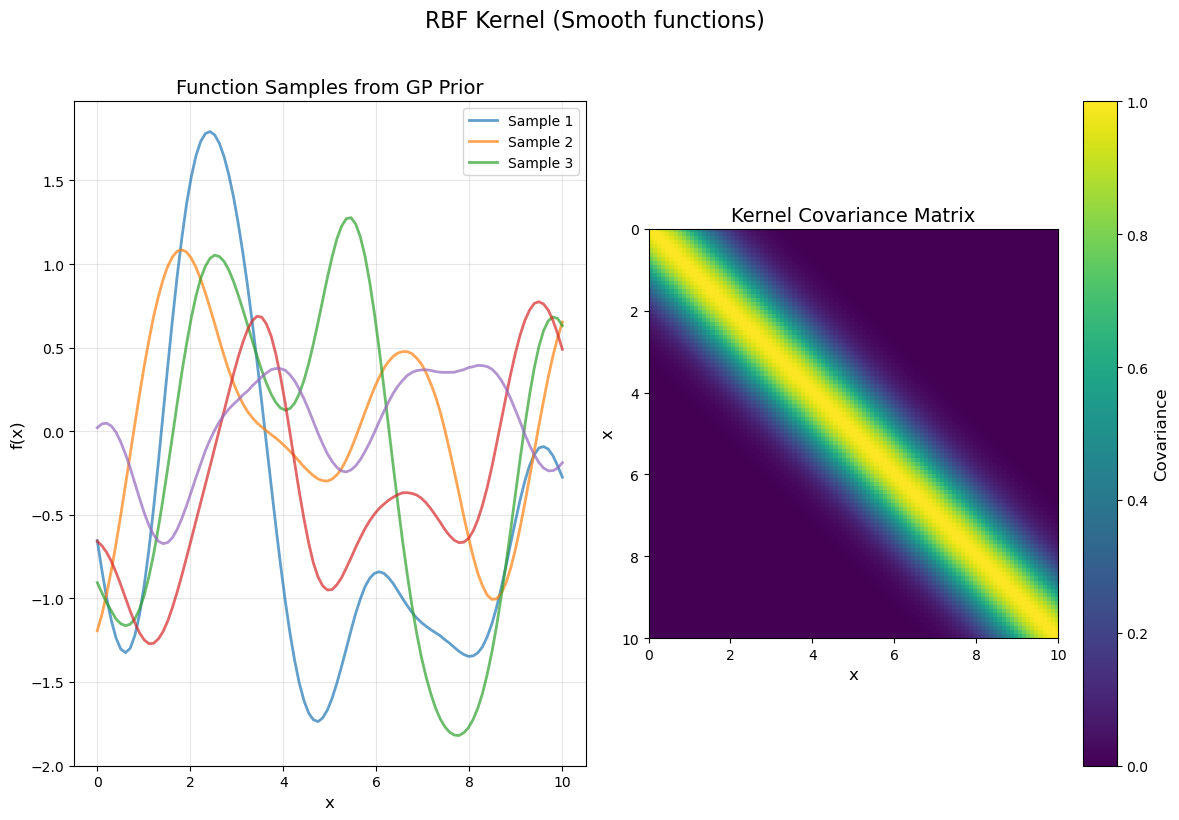

Kernel: RBF({'lengthscale': 1.0, 'variance': 1.0})
Kernel matrix shape: (100, 100)
Kernel matrix condition number: 4.97e+17

2. Linear Kernel:


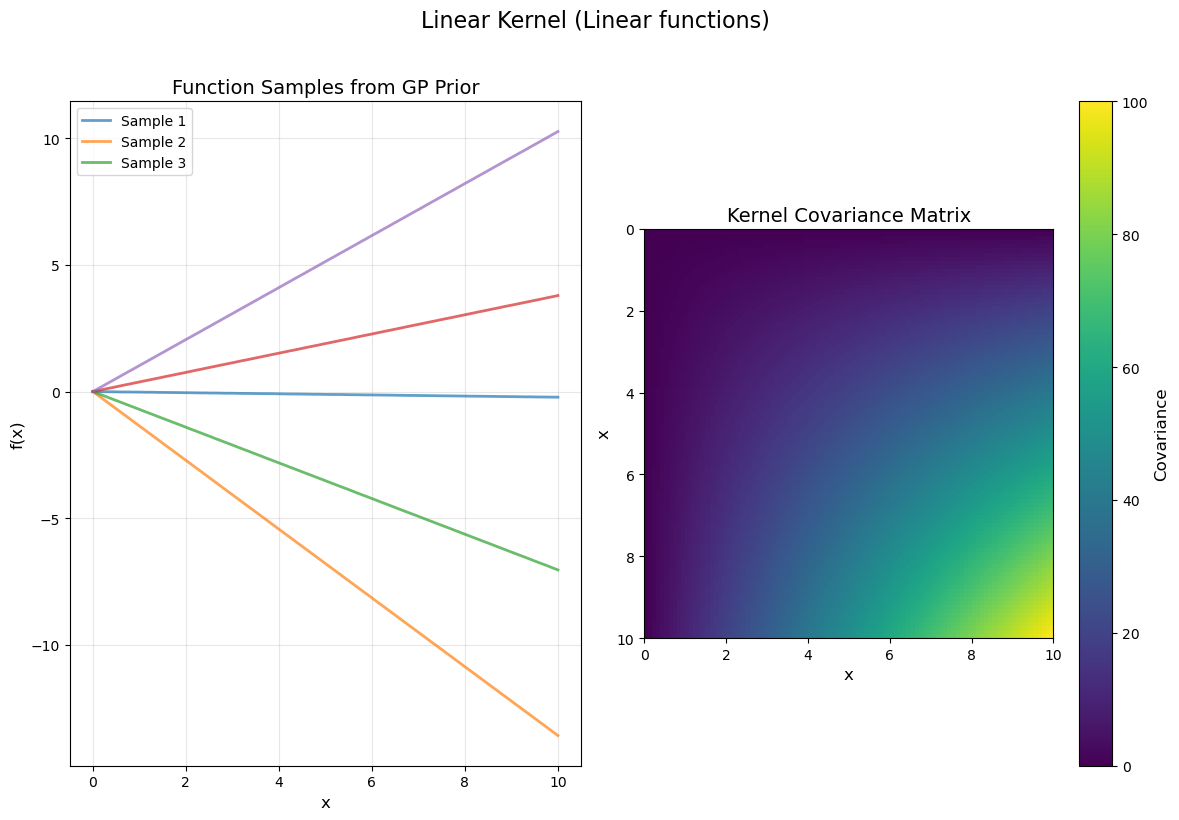

Kernel: Linear({'variances': 1.0})
Kernel matrix shape: (100, 100)
Kernel matrix condition number: inf

3. Periodic Kernel:


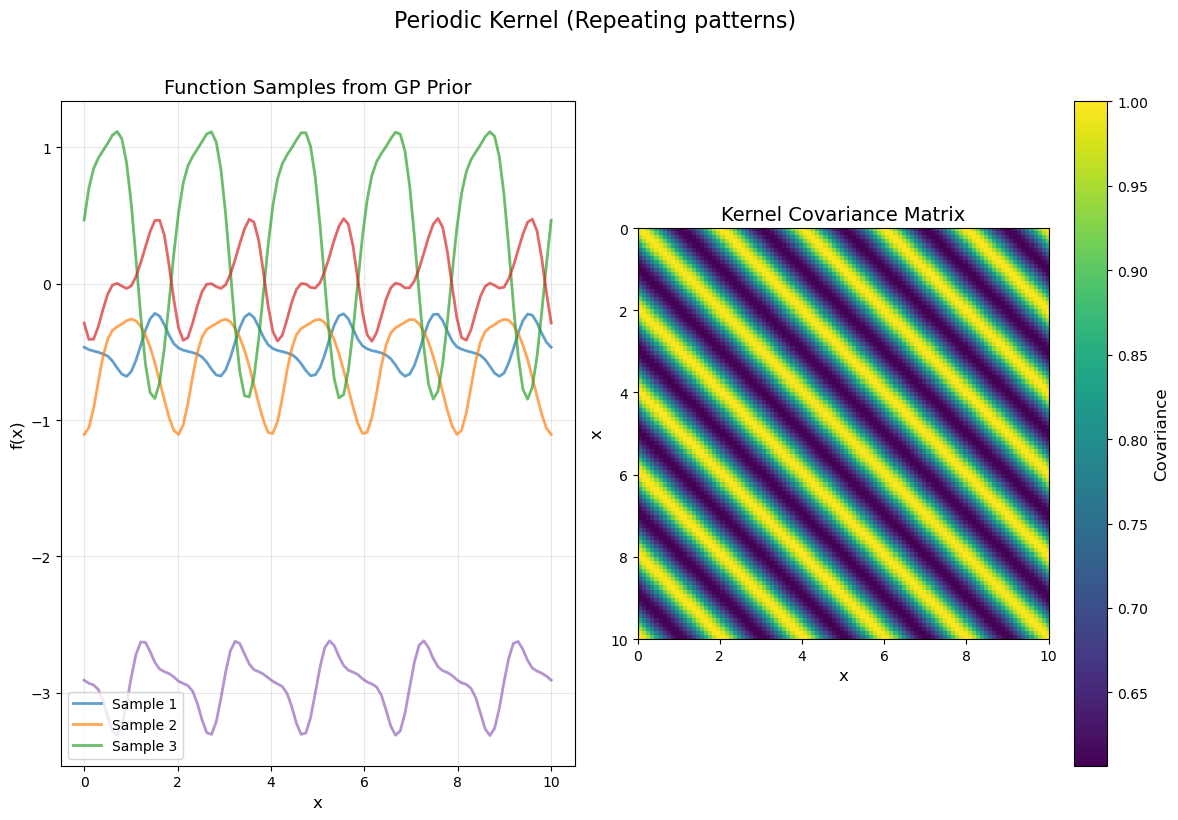

Kernel: Periodic({'period': 2.0, 'variance': 1.0, 'lengthscale': 1.0})
Kernel matrix shape: (100, 100)
Kernel matrix condition number: 2.91e+18

4. RQ Kernel:


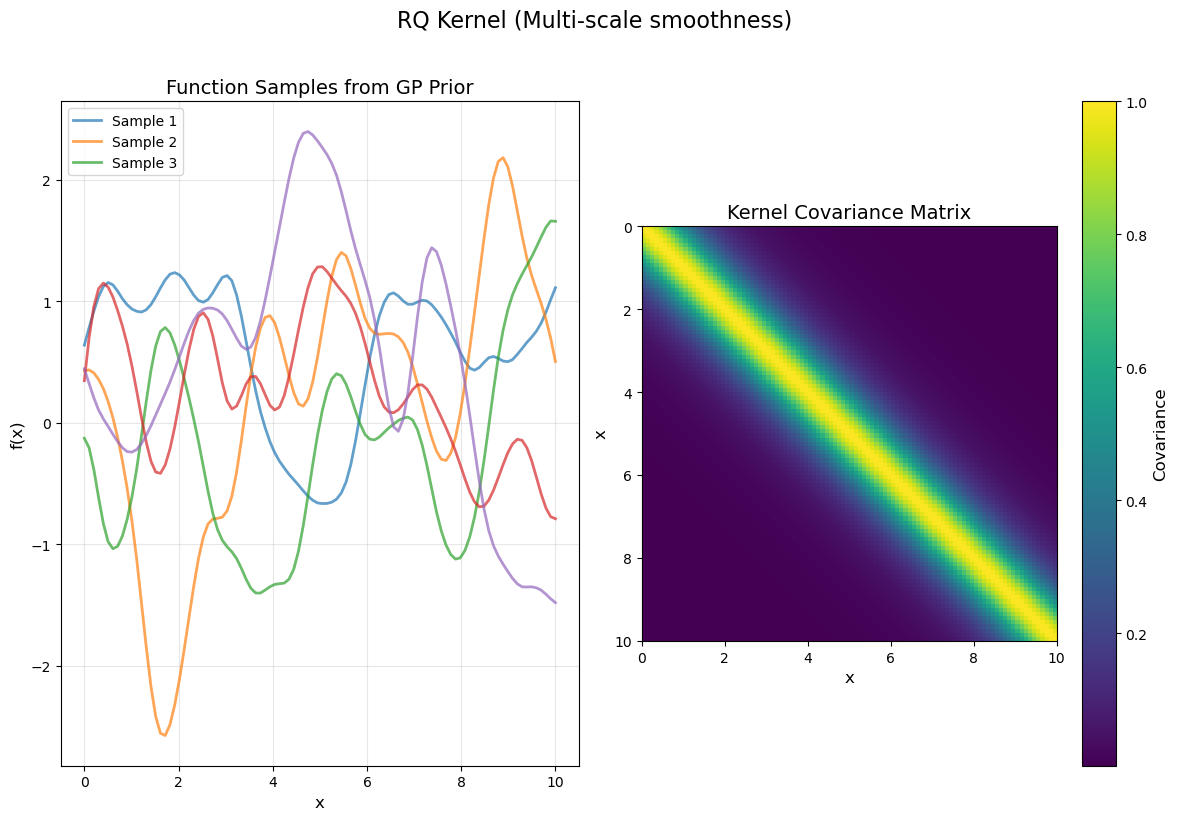

Kernel: RQ({'lengthscale': 1.0, 'variance': 1.0})
Kernel matrix shape: (100, 100)
Kernel matrix condition number: 1.72e+16


In [ ]:
# Updated plotting examples with correct parameters
print("=== Visualizing Individual Kernels ===")

k = KernelFunction()

# 1. RBF kernel
print("\n1. RBF Kernel:")
k_rbf = k.rbf(lengthscale=1.0, variance=1.0)
plot_kernel_function(k_rbf, title="RBF Kernel (Smooth functions)")

# 2. Linear kernel  
print("\n2. Linear Kernel:")
k_linear = k.linear(variances=1.0)
plot_kernel_function(k_linear, title="Linear Kernel (Linear functions)")

# 3. Periodic kernel - need to add lengthscale parameter
print("\n3. Periodic Kernel:")
k_periodic = KernelFunction("Periodic", hyperparams={"period": 2.0, "variance": 1.0, "lengthscale": 1.0})
plot_kernel_function(k_periodic, title="Periodic Kernel (Repeating patterns)")

# 4. RQ kernel
print("\n4. RQ Kernel:")
k_rq = k.rq(lengthscale=1.0, variance=1.0)
plot_kernel_function(k_rq, title="RQ Kernel (Multi-scale smoothness)")

=== Visualizing Composite Kernels ===

Composite Kernel: ((RBF + Linear) * Linear)


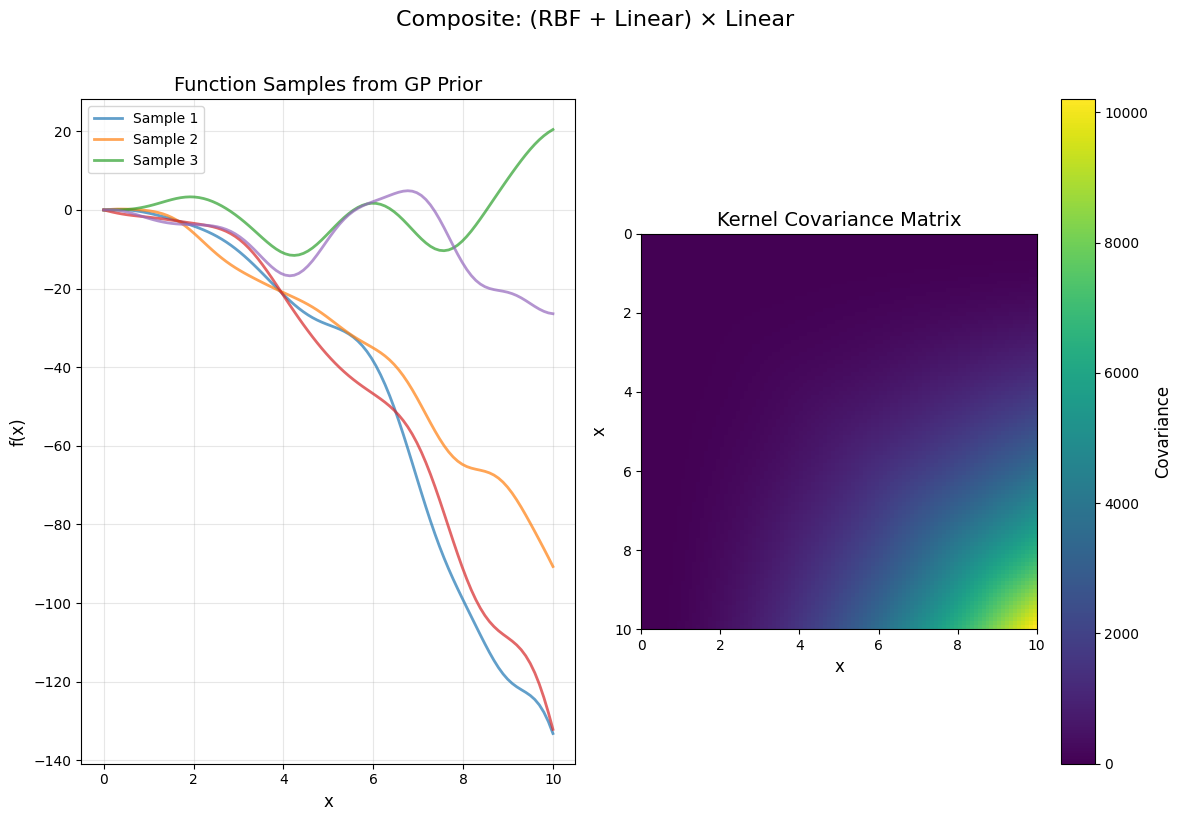

Kernel: ((RBF({'lengthscale': 1.0, 'variance': 1.0}) + Linear({'variances': 0.5})) * Linear({'variances': 2.0}))
Kernel matrix shape: (100, 100)
Kernel matrix condition number: inf

=== Comparing Components vs Composite ===


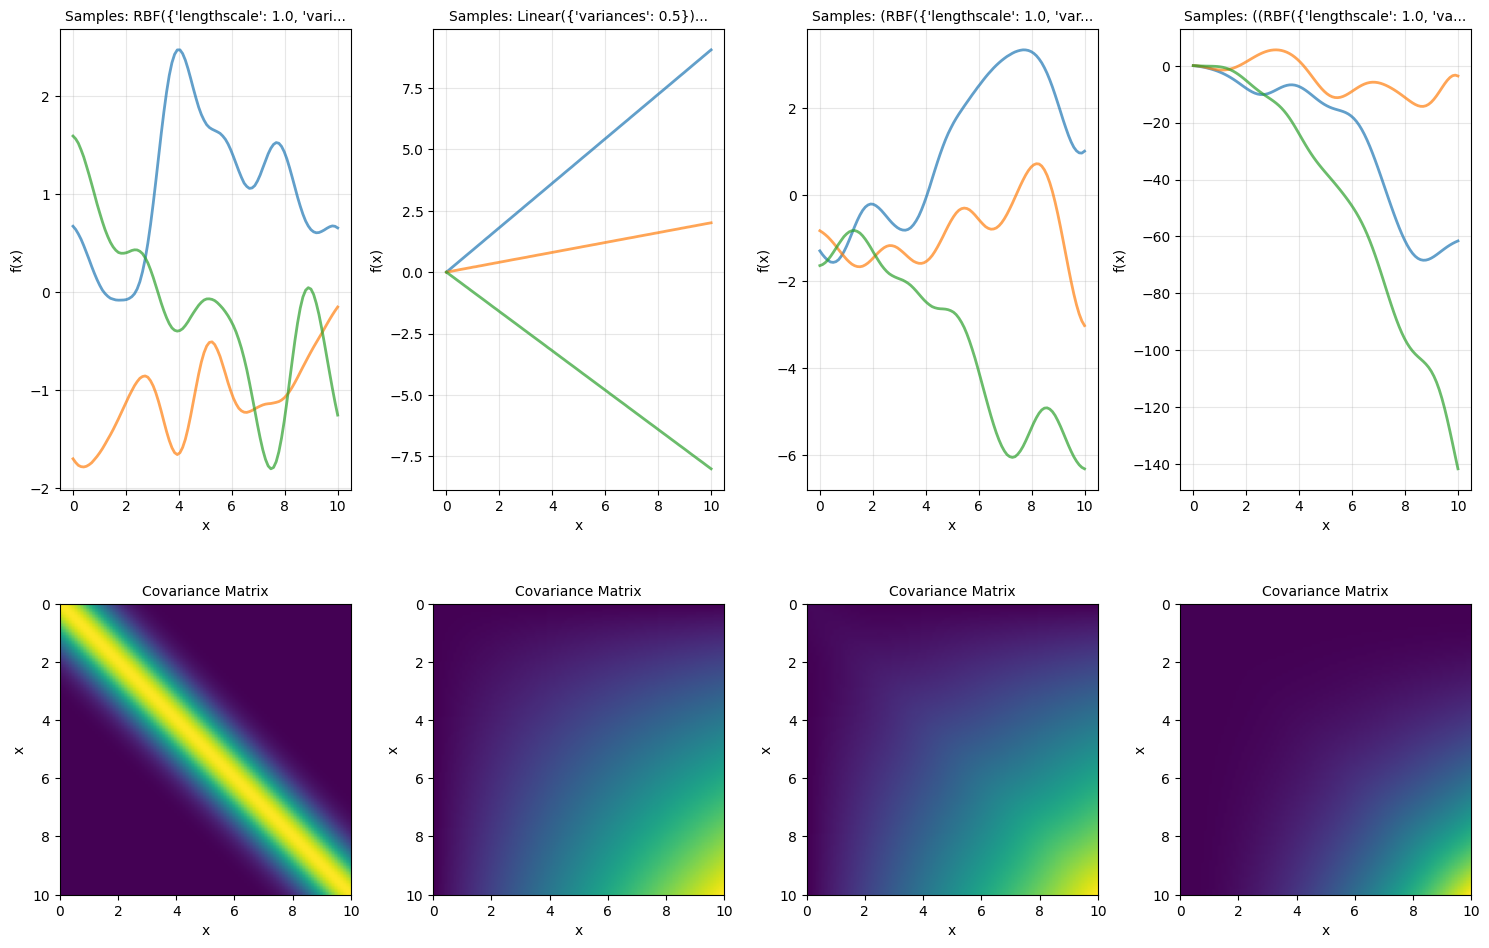

In [ ]:
print("=== Visualizing Composite Kernels ===")

k = KernelFunction()

k1 = k.rbf(lengthscale=1.0)
k2 = k.linear(variances=0.5)
k3 = k1.add(k2).multiply(k.linear(variances=2.0))

print("\nComposite Kernel: ((RBF + Linear) * Linear)")
plot_kernel_function(k3, title="Composite: (RBF + Linear) × Linear")

print("\n=== Comparing Components vs Composite ===")
compare_kernels(
    k1,  # RBF
    k2,  # Linear
    k1.add(k2),  # RBF + Linear
    k3   # (RBF + Linear) * Linear
)

reconstraining parameters std_periodic.period
reconstraining parameters std_periodic.lengthscale
reconstraining parameters std_periodic.variance
reconstraining parameters std_periodic.period
reconstraining parameters std_periodic.lengthscale
reconstraining parameters std_periodic.variance


=== Exploring Different Kernel Combinations ===
Comparing different kernel combinations:


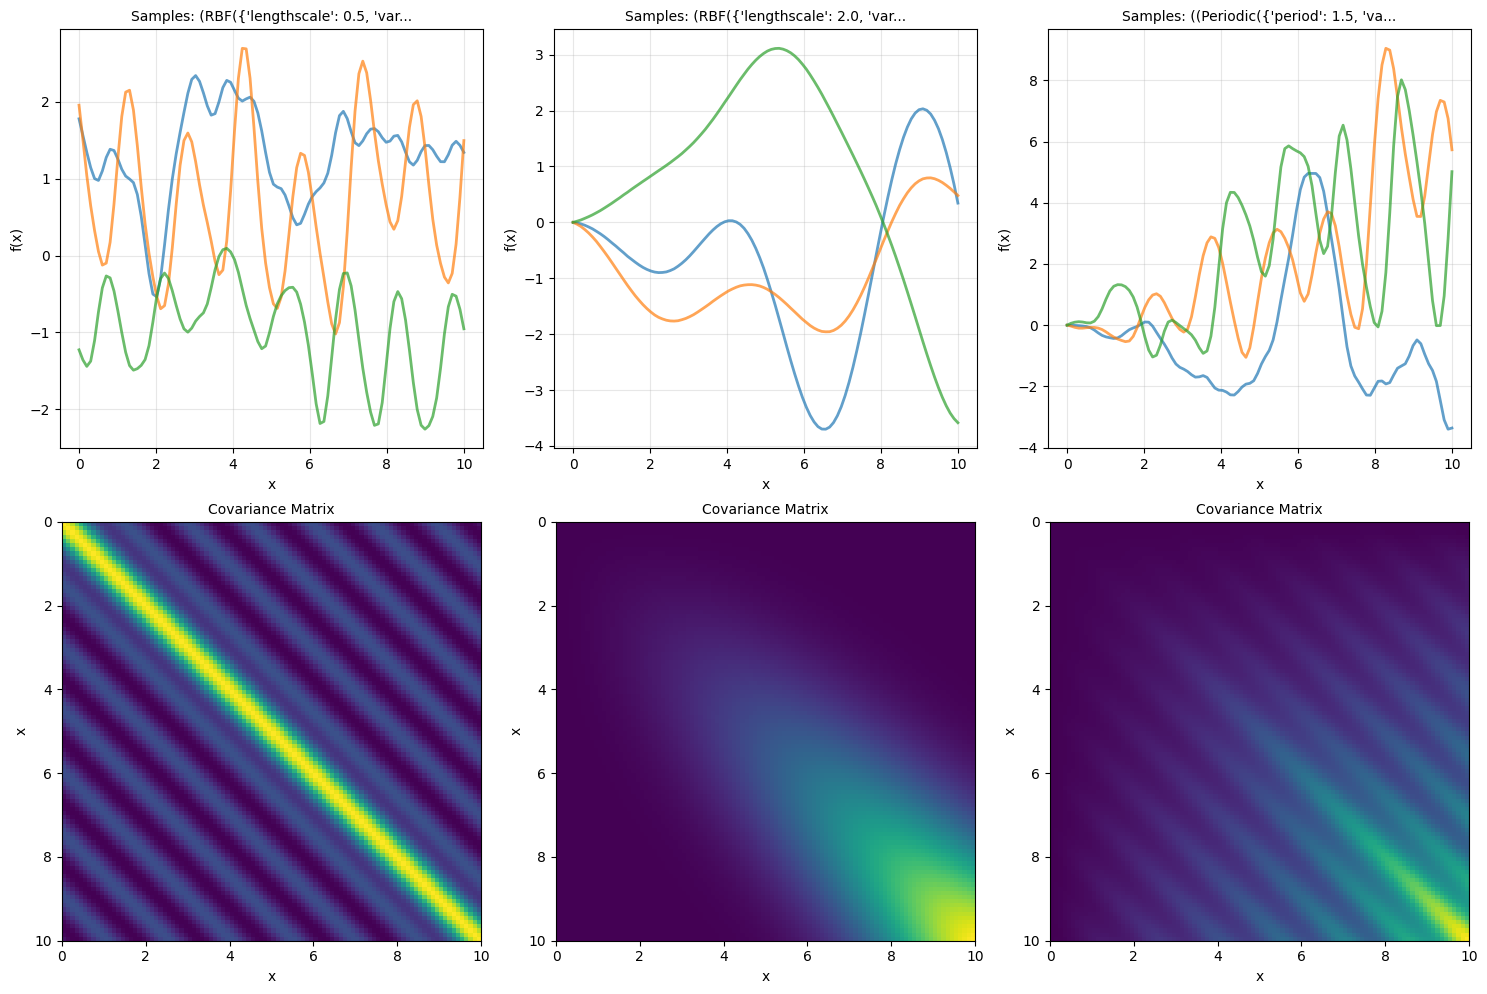

In [ ]:
print("=== Exploring Different Kernel Combinations ===")

k = KernelFunction()

# Different base kernels with proper parameters
rbf_short = k.rbf(lengthscale=0.5, variance=1.0)  # Short lengthscale = more wiggly
rbf_long = k.rbf(lengthscale=2.0, variance=1.0)   # Long lengthscale = smoother
periodic = k.periodic(period=1.5, variance=0.8)   # Periodic with period=1.5
linear = k.linear(variances=0.3)
rq_kernel = k.rq(lengthscale=1.0, variance=0.5)   # RQ kernel

# Create interesting combinations
combo1 = rbf_short.add(periodic)  # Smooth + Periodic
combo2 = rbf_long.multiply(linear)  # Smooth × Linear trend
combo3 = periodic.add(rq_kernel).multiply(linear)  # Periodic + RQ, modulated by Linear

print("Comparing different kernel combinations:")
compare_kernels(combo1, combo2, combo3)

=== Comparing All Base Kernels ===
Side-by-side comparison of all base kernel types:


reconstraining parameters std_periodic.period
reconstraining parameters std_periodic.lengthscale
reconstraining parameters std_periodic.variance


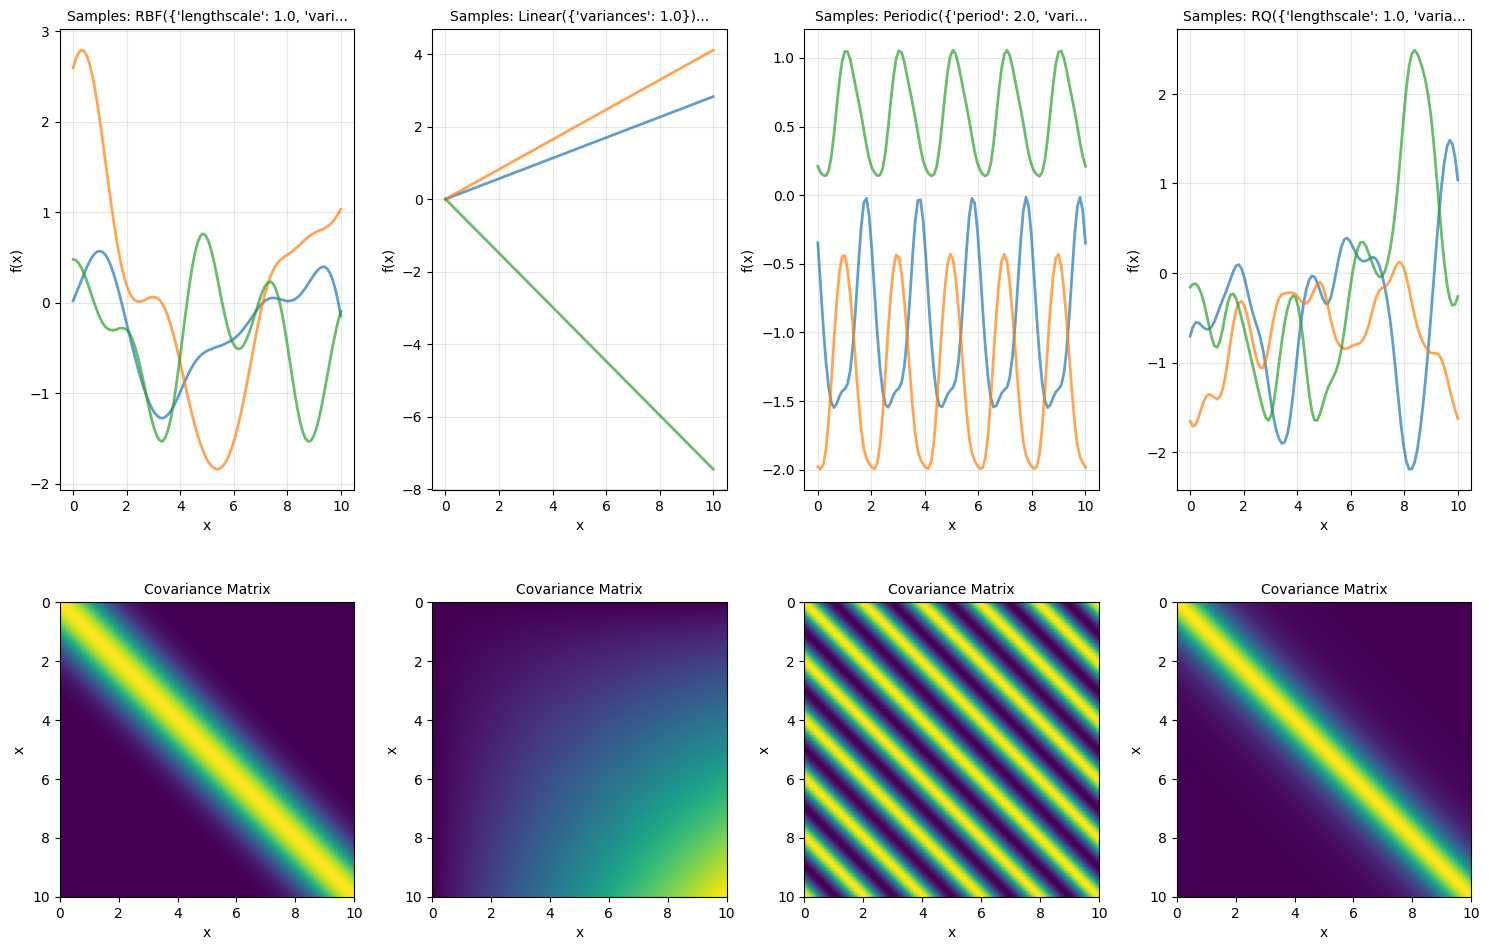

In [ ]:
print("=== Comparing All Base Kernels ===")

k = KernelFunction()

# All four base kernels with consistent parameters
k_rbf = k.rbf(lengthscale=1.0, variance=1.0)
k_linear = k.linear(variances=1.0)
k_periodic = k.periodic(period=2.0, variance=1.0)
k_rq = k.rq(lengthscale=1.0, variance=1.0)

print("Side-by-side comparison of all base kernel types:")
compare_kernels(k_rbf, k_linear, k_periodic, k_rq)